# Forschungspraktikum SS20 
# Semantic Differentials for Wikipedia using the POLAR Framework


The POLAR Framework is a method that enables Interpretability for pre-trained word embeddings. The goal of this project is to produce word embeddings from a Wikipedia dataset, and deploy the POLAR framework to different categories of words (e.g. Countries, Politicians, Music, etc) in order to explain the semantic associations behind concepts on Wikipedia. An evaluation setup should assess the quality of the semantic differentials produced.

In [1]:

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import multiprocessing
from gensim.corpora.wikicorpus import WikiCorpus #https://radimrehurek.com/gensim/corpora/wikicorpus.html
from gensim.models.word2vec import Word2Vec
# for 2d visalization (def display_closestwords_tsnescatterplot):
from sklearn.manifold import TSNE

#From Polar
import gensim
from numpy import linalg

from sklearn.metrics.pairwise import cosine_similarity
# progress bar for .ipyth 
from tqdm import tqdm_notebook as tqdm
import time
from random import shuffle
import sys
import nltk 
from nltk.corpus import wordnet 
import gc
from collections import defaultdict
import random
import json
import os

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

from gensim.test.utils import datapath
#%load_ext autotime

import subprocess

# Function for 2d display of vector distances

In [2]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    #print(arr)
    #print(np.array([model[word]]))
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

    
#display_closestwords_tsnescatterplot(word2vec, 'trump', 300) 

# Load the Antonyms into memory

In [42]:
def loadAntonyms(model,loadMusicAntonyms, loadCountryAntonyms,loadStandardAntonyms): 
    current_model=model #= word2vec
    list_antonym = []



    if loadCountryAntonyms== True:
        
        with open(r'Antonym_sets/country50.txt') as fp:
            for line in fp:
                parts = line.split()
                if parts[1]!=' ':
                    word1 = parts[0]
                    word2 = parts[1]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))
    if loadMusicAntonyms== True:
        with open(r'Antonym_sets/music50.txt') as fp:
            for line in fp:
                parts = line.split()
                if parts[0]!=' ':
                    word1 = parts[0]
                    word2 = parts[1]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))

#POLAR Framework code (https://github.com/Sandipan99/POLAR)
    if loadStandardAntonyms==True:
        with open(r'Antonym_sets/LenciBenotto.val') as fp:
            for line in fp:
                parts = line.split()
                if parts[3]=='antonym':
                    word1 = parts[0].split('-')[0]
                    word2 = parts[1].split('-')[0]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))


        with open(r'Antonym_sets/LenciBenotto.test') as fp:
            for line in fp:
                parts = line.split()
                if parts[3]=='antonym':
                    word1 = parts[0].split('-')[0]
                    word2 = parts[1].split('-')[0]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))

        with open(r'Antonym_sets/EVALution.val') as fp:
            for line in fp:
                parts = line.split()
                if parts[3]=='antonym':
                    word1 = parts[0].split('-')[0]
                    word2 = parts[1].split('-')[0]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))

        with open(r'Antonym_sets/EVALution.test') as fp:
            for line in fp:
                parts = line.split()
                if parts[3]=='antonym':
                    word1 = parts[0].split('-')[0]
                    word2 = parts[1].split('-')[0]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))


    list_antonym = list(dict.fromkeys(list_antonym).keys())
    return list_antonym

# Computing similarty between Antonyms

In [4]:
#POLAR Framework code (https://github.com/Sandipan99/POLAR) :
def computeFinalAntonymsSimilariy(list_antonym): 
    similarity_matrix = defaultdict(list)
    #pre processing of antonyms
    for each_pair in tqdm(list_antonym):
        word1 = each_pair[0]
        word2 = each_pair[1]
        if word1 < word2: ## welches wort länger ist
            similarity_matrix[word1].append(word2)                  #defaultdict(<class 'list'>, {'exclude': ['inscribe']})
            #print(similarity_matrix)
        else:
            similarity_matrix[word2].append(word1)

    # computing similarity of antonyms:
    all_similarity = defaultdict(dict)
    for each_key in tqdm(similarity_matrix):
        for each_value in similarity_matrix[each_key]:
    #       cosine_similarity
            all_similarity[each_key][each_value] = abs(cosine_similarity([current_model.wv[each_key]],[current_model.wv[each_value]])[0][0])

    
    final_antonym_list = []
    for index_counter, each_key in enumerate(tqdm(all_similarity)):
        listofTuples = sorted(all_similarity[each_key].items() ,  key=lambda x: x[1])
        final_antonym_list.append((each_key, listofTuples[0][0]))

    list_antonym = final_antonym_list
    return list_antonym, all_similarity

# Generate the ORTHOGONAL DIMENSION Order
# Subspace selection function

In [5]:
import random

from scipy.spatial.distance import cosine as scipy_cosine
random.seed(42)

def computedimension_similarity_matrix(antonymy_vector):
    t1 = np.array(antonymy_vector)
    dimension_similarity_matrix = defaultdict(dict)
    for index_1, each_dim1 in enumerate(tqdm(t1)):
        for index_2, each_dim2 in enumerate(t1):
            dimension_similarity_matrix[index_1][index_2] = abs(1-scipy_cosine(each_dim1, each_dim2))
    return dimension_similarity_matrix
        
def get_set_score(final_list, each_dim,antonymy_vector):
    final_output = 0.0
    dimension_similarity_matrix=computedimension_similarity_matrix(antonymy_vector)
    for each_vec in final_list:
        final_output += dimension_similarity_matrix[each_vec][each_dim]
    return final_output/(len(final_list))
        
def select_subset_dimension(dim_vector, num_dim):
    working_list = np.array(dim_vector)
    
    working_position_index = [i for i in range(working_list.shape[0])]
    final_position_index = []
    

    print('working list is ready, shape', working_list.shape)
    sel_dim = random.randrange(0, working_list.shape[0])

    final_position_index.append(sel_dim)
    
    working_position_index.remove(sel_dim)

    
    for test_count in tqdm(range(num_dim-1)):
        min_dim = None
        min_score = 1000
        for temp_index, each_dim in enumerate(working_position_index):
#             print(each_dim)
            temp_score = get_set_score(final_position_index, each_dim,dim_vector)
            if temp_score< min_score:
                min_score= temp_score
                min_dim = each_dim
        #print(test_count,min_dim)
        final_position_index.append(min_dim)
        working_position_index.remove(min_dim)
#         print(working_list.shape, len(final_list))
    return final_position_index

# Transform into Polar space function

In [6]:
def transform_to_antonym_space(current_model, output_file_path, binary, current_antonymy_vector_inverse):
    embedding_size = orthogonal_antonymy_vector.shape[0] #current_antonymy_vector_inverse.shape[0]   ##CHANGE THIS ACCORDINGLY!!!
    print('New model size is',len(current_model.wv.vocab), embedding_size)

    temp_file = None
    
    if binary:
        temp_file = open(output_file_path,'wb')
        temp_file.write(str.encode(str(len(current_model.wv.vocab))+' '+str(embedding_size)+'\n'))
    else:
        temp_file = open(output_file_path,'w')
        temp_file.write(str(len(current_model.wv.vocab))+' '+str(embedding_size)+'\n')

    total_words = 0
    for each_word in tqdm(current_model.wv.vocab):
        total_words += 1
        if binary:
            temp_file.write(str.encode(each_word+' '))
        else:
            temp_file.write(each_word+' ')

        new_vector = np.matmul(current_antonymy_vector_inverse,current_model[each_word])

        new_vector = new_vector/linalg.norm(new_vector)

        
        
        if binary:
            temp_file.write(new_vector)
            temp_file.write(str.encode('\n'))
        else:
            temp_file.write(str(new_vector))
            temp_file.write('\n')


    temp_file.close()



# Standard Normal transform

In [7]:
def standard_normal_dist_model(model, new_filename):
    embedding_matrix = []
    embedding_vocab = []

    temp_file = open(new_filename,'wb')
    temp_file.write(str.encode(str(model.vectors.shape[0])+' '+str(model.vectors.shape[1])+'\n'))
    
    for each_word in tqdm(model.wv.vocab):
        embedding_matrix.append(model[each_word])
        embedding_vocab.append(each_word)
    
    embedding_matrix = np.array(embedding_matrix)
    
    print('The shape of embedding matrix is {}'.format(embedding_matrix.shape))
    
    norm_embedding_matrix = (embedding_matrix - embedding_matrix.mean(0))/ embedding_matrix.std(0)
    
    for word_counter, each_word in enumerate(tqdm(embedding_vocab)):
#         assert each_word==embedding_vocab[word_counter],'Not matching!!!'
        
        temp_file.write(str.encode(each_word+' '))
        new_vector = norm_embedding_matrix[word_counter]
        temp_file.write(new_vector)
        temp_file.write(str.encode('\n'))
        
    del embedding_matrix
    del embedding_vocab
    temp_file.close()

# Visulizing polar dimensions

In [29]:
# this function plots the value of a word on a polar dimension in 2d
def plotPolar(left, right, value):
    fig, ax1 = plt.subplots()
    fig.set_figheight(1)
    

    if abs(value)>10:
        fig.set_figwidth(20)
        ar = np.arange(-20,21)   
    else:
        fig.set_figwidth(10)
        ar = np.arange(-10,11)
    ax1.plot(ar, np.zeros_like(ar) + 0, '.')
    ax1.plot(value, 0, 'd', linewidth=2, markersize=20, color='r')
    ax1.set_ylabel(left, color='b',rotation=0, size=20, labelpad=50)
    ax1.set_yticks([])
    ax1.set_xticks(ar)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax2 = ax1.twinx()
    ax2.set_ylabel(right, color='r',rotation=0, size=20, labelpad=50)
    ax2.set_yticks([])
    ax1.grid(False)
    ax2.grid(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    
    
    fig.tight_layout()
    plt.show()

In [28]:
# This function Plots the value for the top 'numberPolar' dimensions of a word
import matplotlib.pyplot as pp
def getMeaningOfWord(strWord,antonymy_vector, model, numberPolar ):
    #print(antonymy_vector)
    word=model[strWord]
    thisdict = {}
    for count, value in enumerate(word):
        thisdict[count]= value
    sortedDic=sorted(thisdict.items(), key=lambda item: abs(item[1]))
    sortedDic.reverse()
   
    for i in range(0,numberPolar):
        cur_Index=sortedDic[i][0]
        originalAntonymIndex=antonymy_vector[cur_Index]
        print(sortedDic[i][1])
        cur_value =sortedDic[i][1]
        leftPolar=list_antonym[originalAntonymIndex][0]
        rightPolar=list_antonym[originalAntonymIndex][1]
        plotPolar(rightPolar, leftPolar, cur_value)
    

# Real code starts here

# Only run next cell if a new Wikipedia dataset is loaded

In [9]:
from ipywidgets import interact, interactive, fixed, interact_manual

def myFunction(trainNewModel):
    return trainNewModel
print("Check if its your first time running this NodeBook")
trainNewModel=interact(myFunction, trainNewModel=True);

Check if its your first time running this NodeBook


interactive(children=(Checkbox(value=True, description='trainNewModel'), Output()), _dom_classes=('widget-inte…

In [10]:
#trainNewModel=True
if trainNewModel==True:
    wiki = WikiCorpus(r"DataSets/enwiki-20200401-pages-articles1.xml-p1p30303.bz2", 
                  lemmatize=False, dictionary={})
    #stores the preprocessed dataset, which reduces runtime for the future
    wiki.save('SavedWord2Vec/wiki.corpus')
    
    sentences = list(wiki.get_texts()) #Iterate over the dump, yielding a list of tokens for each article that passed the length and namespace filtering.



size: The number of dimensions of the embeddings and the default is 100.

window: The maximum distance between a target word and words around the target word. The default window is 5.

min_count: The minimum count of words to consider when training the model; words with occurrence less than this 
count will be ignored. The default for min_count is 5.

workers: The number of partitions during training and the default workers is 3.

sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [11]:
### Compute the Word2Vec model usint following parameters#
# Currently using CBOW for testing because of performance issues of skip gram on my laptop #
if trainNewModel==True:
    print("Training Word2Vec model ...")
    params = {'size': 300, 'window': 5, 'min_count': 5, 
          'workers': max(1, multiprocessing.cpu_count() - 1), 'sample': 1E-3,'sg' : 1}
    word2vec = Word2Vec(sentences, **params)
    ### Save Word2Vec model to file ###
    word2vec.save('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Training")
else:
    ### Loading finished Word2Vec model to memory from file ###
    print("Loading Word2Vec model from file...")
    word2vec = Word2Vec.load('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Loading")


Loading Word2Vec model from file...
Finished Loading


## King- Man + Woman = Queen?

In [12]:
def similarityNameVector(vec, name, model):
    
    cosineSimilarity = np.dot(vec, model.wv[name])/(np.linalg.norm(vec)* np.linalg.norm(model.wv[name]))
    return cosineSimilarity

#print(similarityNameVector(ourQueen,'queen'))



In [13]:
print("Smiliarity of king and queen:", word2vec.wv.similarity('king', 'queen'))
ourQueen= word2vec.wv['king'] - word2vec.wv['man'] + word2vec.wv['woman']
print("Smiliarity of transformed king and queen:", similarityNameVector(ourQueen,'queen',word2vec))

print("The most similar words to out transformation of King to Queen are:")
word2vec.wv.most_similar(positive=[ourQueen], topn=10) # cosine similarity
#word2vec.wv.most_similar(positive=["king"], topn=10)



Smiliarity of king and queen: 0.6234725
Smiliarity of transformed king and queen: 0.57965255
The most similar words to out transformation of King to Queen are:


[('king', 0.7423334717750549),
 ('queen', 0.5796525478363037),
 ('woman', 0.517516016960144),
 ('regnant', 0.5111746788024902),
 ('isabeau', 0.5028153657913208),
 ('throne', 0.5016829967498779),
 ('consort', 0.4985124170780182),
 ('chlothar', 0.48926517367362976),
 ('electress', 0.48813995718955994),
 ('theodelinda', 0.4879298210144043)]

In [14]:
ourJapan= word2vec.wv['france'] - word2vec.wv['paris'] + word2vec.wv['tokyo']
print("The most similar words to out transformation of France to Japan are:")
word2vec.wv.most_similar(positive=[ourJapan], topn=10) # cosine similarity
#word2vec.wv.most_similar(positive=["king"], topn=10)

The most similar words to out transformation of France to Japan are:


[('tokyo', 0.7715462446212769),
 ('japan', 0.7495639324188232),
 ('osaka', 0.6108940839767456),
 ('nagoya', 0.5861287117004395),
 ('kyushu', 0.5758974552154541),
 ('hyōgo', 0.5652197003364563),
 ('miyagi', 0.5611051321029663),
 ('ehime', 0.5560809373855591),
 ('saitama', 0.5548993349075317),
 ('ryukyu', 0.5532717704772949)]

## Usefull functions:

word2vec.wv.similarity('star', 'hollywood')  
word2vec.wv.most_similar('afghanistan')[:20]

# Online training / Resuming training

Advanced users can load a model and continue training it with more sentences and new vocabulary words:

model = gensim.models.Word2Vec.load(temporary_filepath)
more_sentences = [
    ['Advanced', 'users', 'can', 'load', 'a', 'model',
     'and', 'continue', 'training', 'it', 'with', 'more', 'sentences']
]
model.build_vocab(more_sentences, update=True)
model.train(more_sentences, total_examples=model.corpus_count, epochs=model.iter)

cleaning up temporary file
import os
os.remove(temporary_filepath)

## POLAR Framework code (https://github.com/Sandipan99/POLAR) :

# Transformation to polar space

## Compute the task score for different dimension size

In [36]:
def generate_embedding_path(current_model, embedding_path, binary, antonym_vector, curr_dim):
    curr_antonym_vector = antonymy_vector[antonym_vector[:curr_dim]]
    curr_antonymy_vector_inverse = np.linalg.pinv(np.transpose(curr_antonym_vector))
    #transform to polar space and write3s to file
    transform_to_antonym_space(current_model, embedding_path, binary,curr_antonymy_vector_inverse)

In [43]:
#Put it all together

loadMusicAntonyms=True
loadCountryAntonyms=False
loadStandardAntonyms=False
current_model=word2vec

list_antonym=loadAntonyms(model=word2vec,loadMusicAntonyms=True, loadCountryAntonyms=False,loadStandardAntonyms=False)

list_antonym, all_similarity=computeFinalAntonymsSimilariy(list_antonym)

num_antonym = 33#1468
## Find the antonym difference vectors
antonymy_vector = []
for each_word_pair in list_antonym:
    antonymy_vector.append(current_model.wv[each_word_pair[0]]- current_model.wv[each_word_pair[1]])
antonymy_vector = np.array(antonymy_vector)
print(antonymy_vector.shape)



# Get the orthogonal dimension order
orthogonal_antonymy_vector =np.array(select_subset_dimension(antonymy_vector, num_antonym))  


antonym_vector_method = orthogonal_antonymy_vector # we used only the orthogonality method from the original paper

curr_dim = len(antonym_vector_method)#dim_size

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).



(49, 300)
working list is ready, shape (49, 300)


In [44]:

if loadMusicAntonyms==True:    
    embedding_path = r'SavedWord2Vec/polarEmbeddingMusic'+str(curr_dim)+'.bin'
else:
    embedding_path = r'SavedWord2Vec/polarEmbedding'+str(curr_dim)+'.bin'
# model is transformed to polar space and stored as a file
generate_embedding_path(current_model, embedding_path,True,antonym_vector_method, curr_dim)

# Model is loaded from file to memory
print('loading the model')
temp_model = gensim.models.KeyedVectors.load_word2vec_format(embedding_path, binary=True)
print('loading done..')


#Model is tranformed to standard normal and stored to file
if loadMusicAntonyms==True:    
    std_nrml_embedding_path = r'SavedWord2Vec/polarEmbeddingMusic'+str(curr_dim)+'_StdNrml.bin'
else:
    std_nrml_embedding_path = r'SavedWord2Vec/polarEmbedding'+str(curr_dim)+'_StdNrml.bin'

standard_normal_dist_model(temp_model, std_nrml_embedding_path)

del temp_model


New model size is 147612 33


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



loading the model
loading done..


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  



The shape of embedding matrix is (147612, 33)


## Our Testing

In [45]:

path=r'SavedWord2Vec/polarEmbeddingMusic'+str(curr_dim)+'_StdNrml.bin'
# Load the normalized model in Polar dimensions into memory
print("Load Polar model into memory")
word2vecPolar = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
print("Finished Loading")

Load Polar model into memory
Finished Loading


## word2vecPolar: Polar Model
## word2vec: Original Model

In [22]:
word2vecPolar["test"].shape

(33,)

In [23]:
word2vec.wv.most_similar(positive=["queen"], topn=10)

[('elizabeth', 0.6422714591026306),
 ('king', 0.6234725713729858),
 ('isabeau', 0.6121804714202881),
 ('ranavalona', 0.6099308133125305),
 ('margrethe', 0.6072167158126831),
 ('salote', 0.5936083793640137),
 ('consort', 0.5914666652679443),
 ('boleyn', 0.5876452922821045),
 ('regnant', 0.5866461992263794),
 ('isabella', 0.5862259864807129)]

In [24]:
word2vecPolar.wv.most_similar(positive=["angela"], topn=10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('ewen', 0.7431647181510925),
 ('bengough', 0.7329139709472656),
 ('stoiber', 0.7286815643310547),
 ('seaga', 0.7137287855148315),
 ('haig', 0.7072637677192688),
 ('adlai', 0.7067761421203613),
 ('lenihan', 0.7049410343170166),
 ('mckinnon', 0.7025044560432434),
 ('appleby', 0.7014561295509338),
 ('hartz', 0.6994128227233887)]

In [25]:
ourTokyo= word2vecPolar['king'] - word2vecPolar['man'] + word2vecPolar['woman']
print("The most similar words to out transformation of France to Japan are:")
word2vecPolar.most_similar(positive=[ourTokyo], topn=10) # cosine similarity
#word2vec.wv.most_similar(positive=["king"], topn=10)

The most similar words to out transformation of France to Japan are:


[('unborn', 0.7739344835281372),
 ('typhoid', 0.7263432741165161),
 ('triable', 0.7203752398490906),
 ('kuraka', 0.7203114032745361),
 ('ransomed', 0.7131144404411316),
 ('disinherit', 0.7128853797912598),
 ('themself', 0.7108350992202759),
 ('stillborn', 0.7067704796791077),
 ('briseis', 0.7037810683250427),
 ('divulge', 0.6928963661193848)]

In [33]:
#print(list_antonym)
count=0
for i in list_antonym:
    #print(type(i))
    if i == ('common', 'royal'):
        print(count)
    count+=1
print(list_antonym[1166])

IndexError: list index out of range

In [ ]:
orthogonal_antonymy_vector

In [26]:
for i in orthogonal_antonymy_vector:
    print(list_antonym[i])

('black', 'white')
('poor', 'rich')
('asia', 'europa')
('busy', 'calm')
('desert', 'vegetation')
('first', 'third')
('north', 'south')
('hindi', 'muslim')
('green', 'grey')
('modern', 'traditional')
('city', 'land')
('china', 'russia')
('long', 'wide')
('cosmopolitan', 'limited')
('baltic', 'scandinavian')
('large', 'small')
('civilized', 'uncivilized')
('democratic', 'monarchic')
('cold', 'hot')
('developed', 'undeveloped')
('america', 'china')
('hispanic', 'latino')
('catholic', 'muslim')
('big', 'tiny')
('english', 'russian')
('east', 'west')
('white', 'yellow')
('development', 'farming')
('blue', 'grey')
('portuguese', 'spanish')
('buddhism', 'catholic')
('brown', 'white')
('chinese', 'english')


7.619188


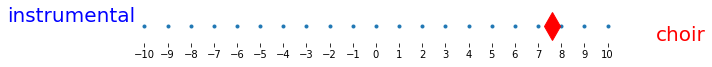

2.0614104


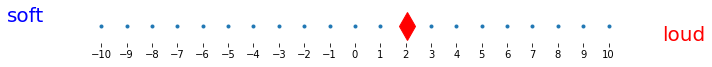

-2.0135622


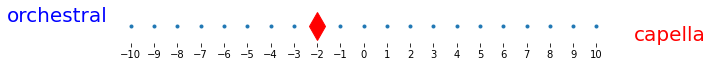

-1.6293662


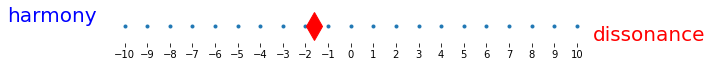

-1.2734542


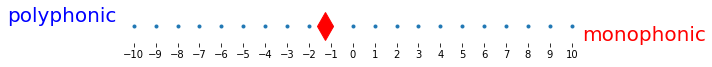

1.2288373


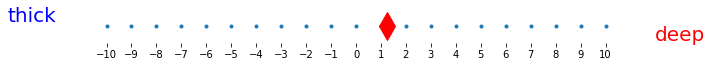

1.1494921


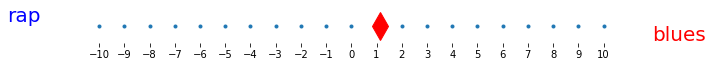

0.97910726


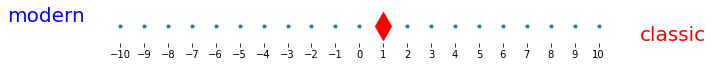

0.91066885


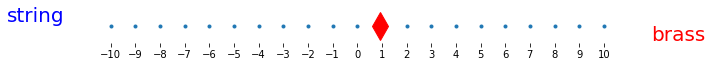

-0.84172845


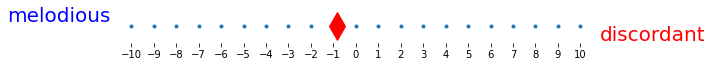

In [59]:
# Plot top 10 polar dimensions for a word
currWord='choir'
howManyDimension=10

getMeaningOfWord(currWord,orthogonal_antonymy_vector, word2vecPolar, howManyDimension )

In [27]:
#print(word2vecPolar["screenshot"])
word=word2vecPolar["water"]
print(word)
#print(list_antonym)
#print(orthogonal_antonymy_vector)
thisdict = {}

#indexedList=[]
for count, value in enumerate(word):
    thisdict[count]= value
#print(thisdict)

sortedDic=sorted(thisdict.items(), key=lambda item: abs(item[1]))
sortedDic.reverse()
#print(sortedDic)
for i in range(0,5):
    cur_Index=sortedDic[i][0]
    originalAntonymIndex=orthogonal_antonymy_vector[cur_Index]
    #print(originalAntonymIndex)
    print(sortedDic[i][1])
    print(list_antonym[originalAntonymIndex])
    #print(sortedDic[i])

[-0.5513357   0.2992909  -0.9792398  -1.1928256  -1.0671536   0.64150095
  1.1393831   0.76281327  1.2610471   0.32421577 -2.5613334  -2.2042937
 -0.05838816 -0.02575333  2.0912066   0.65878993 -0.7909302  -1.0279247
 -0.21182877 -1.3658224  -0.6284247   0.6461692  -0.19993071 -0.69146174
  1.9355266   0.23070632 -0.120572   -0.6441405   0.40501508 -0.82125735
  0.22921325  0.22414668  2.231083  ]
-2.5613334
('city', 'land')
2.231083
('chinese', 'english')
-2.2042937
('china', 'russia')
2.0912066
('baltic', 'scandinavian')
1.9355266
('english', 'russian')
